In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
from torch import tensor
import random
import torch.nn as nn
from plotting import plot_circular_hist as plot_polar_density
from manifold import Circle, Sphere, Manifold
from sdes import CircularBrownianMotion, CircularGenerative

# Circle
Let us work with the circle as a simple one dimensional manifold emboddied in the two dimensional xy plane. 
We choose an arbitrary distribution $\mathbb{P}_{0}$ over the circle(data distribution).

## data distribution over the circle

In [24]:
def sample_from_P0_theta(n: int = 1):
  a = (torch.rand(n) * 70 + 40)/(360) #uniform over (40, 110) degrees, the output is in radian though
  b = (torch.rand(n) * 50 + 190)/(360)
  mask = torch.bernoulli(torch.ones(n)*0.5)<0.5
  return torch.where(mask, a, b)

In [25]:
def sample_from_P0_xy(n: int = 1):
  return Circle.invphi(sample_from_P0_theta(n))

In [30]:
theta = sample_from_P0_theta(n = 8).unsqueeze(-1)
xy = Circle.invphi(theta)
print(f'theta: {theta}')
print(f'xy: {xy}')
print(f'phi(xy): {Circle.phi(xy)}')

theta: tensor([[0.6466],
        [0.1750],
        [0.2977],
        [0.5869],
        [0.2761],
        [0.6394],
        [0.1532],
        [0.6316]])
xy: tensor([[0.7981, 0.6025],
        [0.9847, 0.1741],
        [0.9560, 0.2933],
        [0.8327, 0.5538],
        [0.9621, 0.2726],
        [0.8025, 0.5967],
        [0.9883, 0.1526],
        [0.8071, 0.5904]])
phi(xy): tensor([0.6466, 0.1750, 0.2977, 0.5869, 0.2761, 0.6394, 0.1532, 0.6316])


(<Figure size 432x288 with 1 Axes>, <PolarAxesSubplot:>)

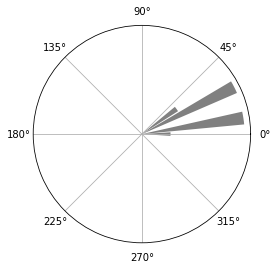

In [31]:
plot_polar_density(sample_from_P0_theta(n=1000))

# Modeling the data: The Q

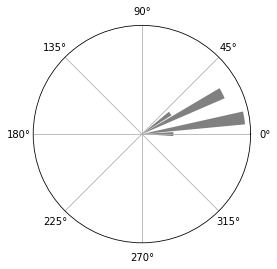

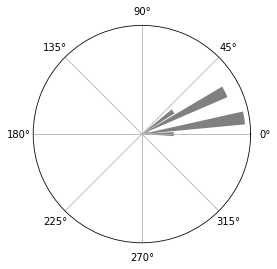

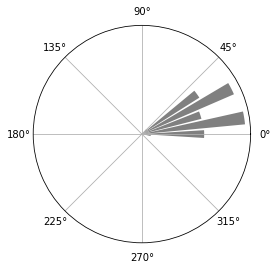

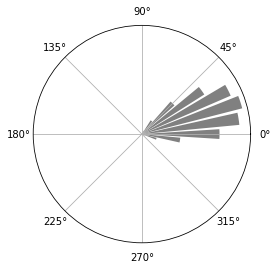

In [10]:
#plotting the diffusion process
x = sample_from_P0_theta(n = 2000)
sde = CircularBrownianMotion()
plot_polar_density(x)
for t in [0.001, 0.01, 0.05]:
    y = sde.sample(x, t)
    plot_polar_density(y)

In [11]:
# this is a loss just for training without any part that is constant with respect to a, it is not ELBO
def aloss(detG, a, sigma, y, t):
  '''
  G: dterminant of metric tensor
  a: 
  sigma: note it is equivalent to g(X, t)
  y: samples of Xt under Q measure, i.e. samples from Q diffusion process
  t: times of the samples y
  '''
  # norm of a
  norm = a(y,t).norm(dim=1).unsqueeze(-1)**2

  # V
  ivgol = torch.sqrt(1/detG(y))

  sa = (sigma(y, t) @  a(y, t).unsqueeze(-1)).squeeze(-1) #shape: [32, 1]
  g = torch.autograd.grad(sa[:, 0].sum(), y, create_graph=True, retain_graph=True)[0]
  ll = -0.5*norm - g

  loss = -ll
  return loss

In [12]:
class AModule(nn.Module):
  def __init__(self, d, w, emb_size: int = 64):
    '''
    d: the dimension of the manifold
    w: the dimension of the brownian motion
    '''
    super(AModule, self).__init__()
    self.net = torch.nn.Sequential(
        nn.Linear(3, emb_size),
        nn.ELU(),
        nn.Linear(emb_size, emb_size),
        nn.ELU(),
        nn.Linear(emb_size, 1)
    )
    
  def forward(self, x, t):
      return self.net(torch.cat([Circle.invphi(x), t], 1))

In [15]:
a = AModule(d=1, w=1)
n_sample = 512
sde = CircularBrownianMotion()
opt = torch.optim.Adam(a.parameters(), lr=0.002)
T = 0.04

In [17]:
for i in range(10000):
  x = sample_from_P0_theta(n = n_sample).unsqueeze(-1)
  t = (torch.rand(n_sample) / n_sample + torch.arange(n_sample)/n_sample).unsqueeze(-1) * T
  y = sde.sample(x, t).requires_grad_(True)

  opt.zero_grad()
  loss = aloss(Circle.g, a, sde.g, y, t).sum() / n_sample
  if i%500 == 0:
    print(f'loss: {loss}')
  loss.backward()
  opt.step()

loss: -0.06635690480470657
loss: -8.192887306213379
loss: -7.902949810028076
loss: -8.32178783416748
loss: -8.880899429321289
loss: -10.721370697021484
loss: -12.855735778808594
loss: -12.615478515625
loss: -17.26091766357422
loss: -14.188031196594238
loss: -16.769006729125977
loss: -16.964271545410156
loss: -14.165035247802734
loss: -16.4625244140625
loss: -16.060487747192383
loss: -18.472684860229492
loss: -19.15015411376953
loss: -21.178266525268555
loss: -20.135150909423828
loss: -21.7750244140625


## sampling from the diffusion

(<Figure size 432x288 with 1 Axes>, <PolarAxesSubplot:>)

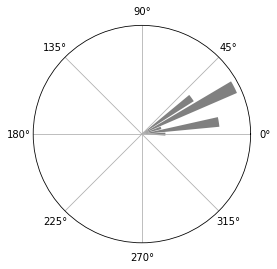

In [33]:
#plotting the diffusion process
gsde = CircularGenerative(sde.g, a, T = T)
x0 = torch.rand(1024, 1)
x = gsde.sample(x0, torch.ones(1024, 1) * T, 1000)
plot_polar_density(x.detach().cpu().numpy())

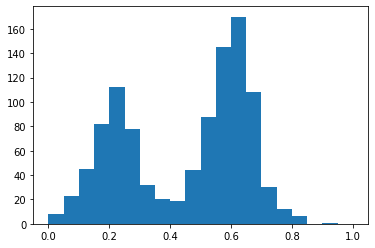

In [34]:
_ = plt.hist(x.data.numpy(),20, range=(0,1))

(<Figure size 432x288 with 1 Axes>, <PolarAxesSubplot:>)

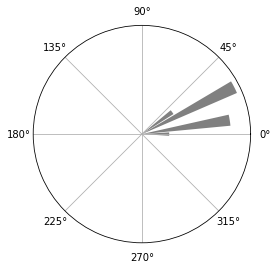

In [35]:
x = sample_from_P0_theta(n = n_sample).unsqueeze(-1)
x = sde.sample(x, 0.0001).requires_grad_(True)
plot_polar_density(x.detach().cpu().numpy())

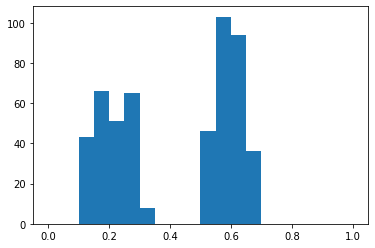

In [36]:
_ = plt.hist(x.data.numpy(),20, range=(0,1))